<h1 style="text-align: center;font-size:250%">F I X E R  1</h1>

This notebook takes 1D spectra from a red and blue arms reduced with the DRAGONS pipeline, **combines multiple exposures** (if any), **normalizes** the spectra with and automatic continuum fit or an user-defined continuum, **calculates the radial velocity** of the object by performing a cross corelation with a metal-poor template over multiple wavelength ranges, and **radial velocity corrects** the spectrum. Additionally there is the option to perform a barycentric velocity correction.  

<span style="font-size:110%"> **Inputs:** </span><br>
The _dragons output files from the science reduce in the dragons pipeline for the red _and_ blue arms (one of which which should include the star data, preferably sky-subtracted) and  the 1D spectra (red and blue) obtained after the `reduce -r write1DSpectra {observation}_{camera}00?_dragons.fits -p var=True ` command (i.e. the .dat files **must** include variance). For example, all files for your star labelled as:   
- S20240504S0241_blue00?_dragons.fits
- S20240504S0241_red00?_dragons.fits
- S20240504S0241_blue00?_dragons_00?.dat
- S20240504S0241_red00?_dragons_00?.dat

Where '?' in red00? indicates the exposure number and '?' in _00?.dat indicates the IFU<br>
To keep files organaized, it may be useful to store all your stars data in a folder labeled with the first series of numbers common to all your star's files; i.e S20240504S0241. 


<span style="font-size:110%"> **Outputs:** </span><br>
By default, this notebook saves its output files in the same folder in which it finds the input files. The labels also resemble the input files in structure in order to easily identify which observation date and number the reduction belong to. The outputs are:
- An .xyz and a .dat file of combined exposures (1 x blue, 1 x red): 
    - S20240504S0241_00?_blue.xyz / .bi 
    - S20240504S0241_00?_red.xyz / .bi
- An .xyz file of normalized spectrum (2 x blue, 1 x red):
    - S20240504S0241_00?_blue1_norm.xyz 
    - S20240504S0241_00?_blue2_norm.xyz 
    - S20240504S0241_00?_red_norm.xyz 
- A .txt file with the radial velocities:
    - S20240504S0241_00?_radialVelocities.txt
- An .xyz file with radial velocity corrected, normalied spectrum (1 x blue, 1 x red):
    - S20240504S0241_00?_blue_normrv.xyz
    - S20240504S0241_00?_red_normrv.xy

where '?' indicates the IFU<br>
This notebook does <u>not</u> combine the blue and the red arms. 

<span style="background-color: #cdd5c1">  </span>

<span style="font-size:110%"> **Required installations:** </span><br>
This notebook requires python modules `emcee` and `corner` which can be installed with `pip`.

In [1]:
# Import all necessary modules and packages 
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
from scipy.stats import sigmaclip
import scipy.stats as stats
import scipy.ndimage as nd
from scipy import interpolate
from scipy.signal import medfilt
from scipy.ndimage import median_filter 
from datetime import datetime, date, time, timedelta
import astropy
import astropy.coordinates as astrocoord
from astropy.time import Time
from astropy import units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.io import fits
from astropy.stats import sigma_clip
from copy import deepcopy
import os 
from os import listdir
import shutil
import glob
import itertools

import sys
sys.path.insert(0, '../FIXER_1/')
from apo_tools.spec_tools import Spectrum
from apo_tools.turbospec_tools import SpectrumTS

import sys
sys.path.insert(0, '../FIXER_1/apogee/')
import external.doppler.doppler as doppler

import sys
module_path = os.path.join('../FIXER_1/asap_lib/')
if module_path not in sys.path:
    sys.path.append(module_path)
import spectra as sa

import sys
#module_path = os.path.abspath(os.path.join('/astro/adovgal/ASAP'))

module_path = os.path.abspath(os.path.join('../../ASAP'))
if module_path not in sys.path:
    sys.path.append(module_path)

import asap_lib.moog_funcs as mf
import asap_lib.auto_atmosphere as aa
import asap_lib.calc_abunds as calc_abunds
import asap_lib.line_list_utils as llu
import asap_lib.spectra as sa

GEMINI_SOUTH_LOC=astrocoord.EarthLocation.from_geodetic((-70,44,12.096),(-30,14,26.700),height=2722.,ellipsoid='WGS84')

        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


In [2]:
# Some necessary functions
class SpecNormRV(Spectrum):
        
    def add_template(self, template):
        self.original_template = template
        self._interpolate_template()
            
    def rv_correct(self, wave_range=None, vel_range=None, inspect=False, 
                   shift_wavelength=True, fill_nan=True, fill_value=1):
        
        if wave_range is None:
            wave_range = [3500, 10600]  
        if vel_range is None:
            vel_range = [-500, 500]
        
        inwave = self.wavelength
        intemp = self.template.flux
        inspec = self.flux
        inerr = np.sqrt(self.variance)

        if fill_nan:
            inspec = np.array(inspec)
            inspec[~np.isfinite(inspec)] = 1
            inerr[~np.isfinite(inspec)] = 1.e6

        wave_mask = (inwave > wave_range[0]) & (inwave < wave_range[1])
        out = doppler.rv.specxcorr(wave=inwave[wave_mask],
                                   tempspec=intemp[wave_mask],
                                   obsspec=inspec[wave_mask], 
                                   obserr=inerr[wave_mask],
                                   plot=inspect,
                                   maxlag=vel_range)
        
        self.rv = out['vrel'][0]
        self.rv_err = out['vrelerr'][0]
        
        if shift_wavelength:
            self.wavelength=self.vel_shift(-1.*self.rv)
            self._interpolate_template()
            
    def barycenter_correction(self, ra, dec, date_obs, utstart, exptime, verbose=False):
        # Set up a SkyCoord for this ad
        sc = astrocoord.SkyCoord(ra, dec,unit=(u.hr, u.deg, ))

        # Compute central time of observation
        dt_start = datetime.combine(
            datetime.strptime(date_obs, '%Y-%m-%d').date(),
            datetime.strptime(utstart, '%H:%M:%S').time(),
        )

        dt_midp = dt_start + timedelta(
            seconds=exptime/2.0
        )
        dt_midp = Time(dt_midp)

        # Vanilla AstroPy Implementation
        corr_fact = sc.radial_velocity_correction('barycentric',obstime=dt_midp,location=GEMINI_SOUTH_LOC)
        corr_fact = corr_fact.to(u.km / u.s)
        self.rv_bary = self.rv + corr_fact.value
            
        if verbose:
            print(f'Correction Factor = {corr_fact:.2f}')
            print(f'RV = {self.rv:.2f}')
            print(f'Barycentric RV = {self.rv_bary:.2f}')
        
    def _interpolate_template(self):
        ip=interpolate.InterpolatedUnivariateSpline(self.original_template.wavelength,self.original_template.flux,k=3,ext=0)
        self.template = Spectrum(self.wavelength,ip(self.wavelength))        

# ----------------------------------------------------         
def comb_blue(blue1, blue2):
    b1w = np.array(blue1['wavelength']) ; b1f = np.array(blue1['flux']) ; b1v = np.array(blue1['variance']) ;
    b2w = np.array(blue2['wavelength']) ; b2f = np.array(blue2['flux']) ; b2v = np.array(blue2['variance']) ;
    wave = np.concatenate([b1w,b2w]) ; flux = np.concatenate([b1f,b2f]) ; varn = np.concatenate([b1v,b2v])
    return wave,flux,varn
    
# ----------------------------------------------------         
# def rv_error(variances):
#     # variances is array-type
#     T = 0
#     for i in variances:
#         T+= i**2
#     return np.sqrt(T/len(variances))

def rv_error(rvs):
    return np.std(rvs)

### Optional: Flatten .fits to dat  before Reduction
If you have .fits files intead of .dat files left from the pipeline, use the following cell to flatten them. 

## Indicate file path
<span style="text-align:left; background-color: #cdd5c1"> This cell requires user input</span><br>
This cell allows the rest of the notebook to find/save files. Indicate the observation number (that which includes the date) under `star`, the IFU (usually _001 or _002) in `num`, the path to the FIXER_1 folder in your directories in `path`, and the path to the folder containing your star/observation's data *within* the FIXER_1 folder in `fipath`.

The paths and file names are broken down in this manner because each component is used separately somewhere in the notebook. 

In [3]:
# Indicate the object and confirm file path.

star = 'S20240927S0034'
num  = '_001'
end  = '_dragons' + num  

path =  f'/astro/venn/GHOST.data/C19ZZ/' 
#fipath = path  + f'test/'
fipath = path
spath  = fipath + star                                        

In [4]:
spath

'/astro/venn/GHOST.data/C19ZZ/S20240927S0034'

# Combine Exposures
The following cell combines multiple exposures (if any) of each arm for the indicated IFU in `num` and saves the stack as both .bin and .xyz files. This cell must be run even if there is only one exposure per arm. 

Make the messages this cell prints indicate that the notebok was able to find and access your exposures. If not, adjust the cell above so it can. 
<br>If an ERROR message apears indicating the first line of the .dat file can't be read, go into the file and comment out the line `wavelength flux variance`, but **don't delete it**; have it be: `# wavelength flux variance`.

In [5]:
for camera in ['blue', 'red']:
    
    naming = '*{}*'+ end + '.dat'
    condition = naming.format(camera)
    obs = glob.glob(spath+condition)
    
    print('Found {} exposures to combine: '.format(len(obs)))
    print( * obs, sep = "\n")

    # --------------------------------
    waves  = []
    fluxes = []
    varian = []

    for item in obs:
        wave, flux, var = sa.read_spec(item, ftype ='xyz')

        waves.append(wave)
        fluxes.append(flux)
        varian.append(var)
    
    # --------------------------------
    pairs =  list(itertools.combinations(range(len(waves)), 2))

    for pair in pairs:
        value = np.array_equal(waves[pair[0]], waves[pair[1]])
        if value == False:
            print('Wavelength arrays not equivalent. Do not proceed')
            break

    if len(waves) > 0:
        # -------------------------------- Median Combine flux and combine error with Poisson statistics 
        finalWave = waves[0]
        finalFlux = np.median(fluxes,axis = 0)
        #finalErr = np.zeros(len(finalWave))
        finalErr = np.sqrt( sum(i*i for i in varian) ) / len(waves)

        # -------------------------------- Save the output as .xyz and .bin files 
        sa.write2xyz(finalWave, finalFlux, finalErr, spath +num+'_{}'.format(camera))
        sa.write2bin(finalWave, finalFlux, finalErr, spath +num+'_{}'.format(camera))

        print('Saved combination of {} {} camera images'.format(len(waves), camera))
        # --------------------------------

    else:
        print('No {} camera files found'.format(camera))


Found 1 exposures to combine: 
/astro/venn/GHOST.data/C19ZZ/S20240927S0034_blue001_dragons_001.dat
Saved combination of 1 blue camera images
Found 1 exposures to combine: 
/astro/venn/GHOST.data/C19ZZ/S20240927S0034_red001_dragons_001.dat
Saved combination of 1 red camera images


<br>

### Patch NaN and Inf values   (OPTIONAL)
Sometimes spectra have nan and inf values which can be annoying to work with. The following bit of code will change all inf and nan flux values in a spectrum to a specified value (This can be performed at any stage ). <br>
This cell is "turned off" by default but included just in case the user needs it.

<br>

__________

# Normalization
<span style="background-color: #cdd5c1"> This routine requires user input </span><br>
This section performs the normalization of the spectra. In order to achieve a better continuum estimation, the blue arm is split in two sections: blue1 spans the wavelength region [3700, 4405] Å while blue2 spans the region [4395, 5305] Å. The two sections of the blue arm are re-combined in cell #16.  

There are two methods which can be used for normalization, Method A consists in an automatic continuum estimation by use of a smooth kernel and sigma clipping, while Method B consists in a user specified continuum estimation. 

The following cell reads each of the files separately, this means you will run the routine at least three times (making sure to save your favourite fits) in order to obtain a normalized red arm, a normalized blue1 section and a normalized blue2 section (i.e. there needs to be three output files). 

In [15]:
# Indicate the camera and number(if applicable)

camera = 'blue'             # options are:'red' or 'blue'
nblue  = '1'               # if blue, options are: '1' or '2' 
ftyp   = 'bin'             # type of file we want to read 

# -------------------------------------------------------------------------------

fpath  = spath + f'{num}_{camera}.{ftyp}'  # Path to combined-exposures files

# Read the files
w, f, e = sa.read_spec(fpath, ftype = ftyp)

# This selection crops off noisey ends and splits the blue spectra
if camera == 'red':
    w_min = 5295
    w_max = 9500 #9100
    colour = 'tab:orange'
    contr  = 'tab:blue'

elif camera == 'blue':
    if nblue == '1':
        w_min  = 3700     
        w_max  = 4405    
        colour = 'royalblue'
        contr  = 'tab:orange'
        
    elif nblue == '2':
        w_min  = 4395
        w_max  = 5305
        colour = 'tab:blue'
        contr  = 'tab:orange'

ind = np.where( (w >= w_min) & (w <= w_max ) )[0]

wave = w[ind]
flux = np.array(f[ind].flatten(), dtype='float32')
error = np.array(e[ind].flatten(), dtype='float32')

print("File being read:\n",fpath)

File being read:
 /astro/venn/GHOST.data/C19ZZ/S20240927S0034_001_blue.bin


### Method A: Auto Continuum normalize
Use the plots to visualize the continuum fit. Adjust the smooth_kernel to change the shape of the continuum in the second plot and change the sigma variables to move the fit up or down on the last plot. Works best for `red` and `blue2`.

In [16]:
# Indicate values for the following parameters and run the cell to perform the normalization

if camera == 'red':
    smooth_kernel = 2000   
    sigma_lower = 1.5     
    sigma_upper = 3       

if camera == 'blue':
    if nblue == '2':
        smooth_kernel = 900    
        sigma_lower = 1.1      
        sigma_upper = 3       
    
    elif nblue == '1': # Honestly doesn't really change spectrum depending on choices.
        smooth_kernel = 400    
        sigma_lower = 1.1      
        sigma_upper = 3       


# smooth_kernel = 900   # ~2000 red, ~900 blue2, 
# sigma_lower = 1.1      # ~1.5 red, ~1.1 blue2, 
# sigma_upper = 3        # ~3 red, ~3 blue2

norm, filt = sa.contnorm_2stage(flux, smooth_kernel, sigma_lower, sigma_upper)

<IPython.core.display.Javascript object>


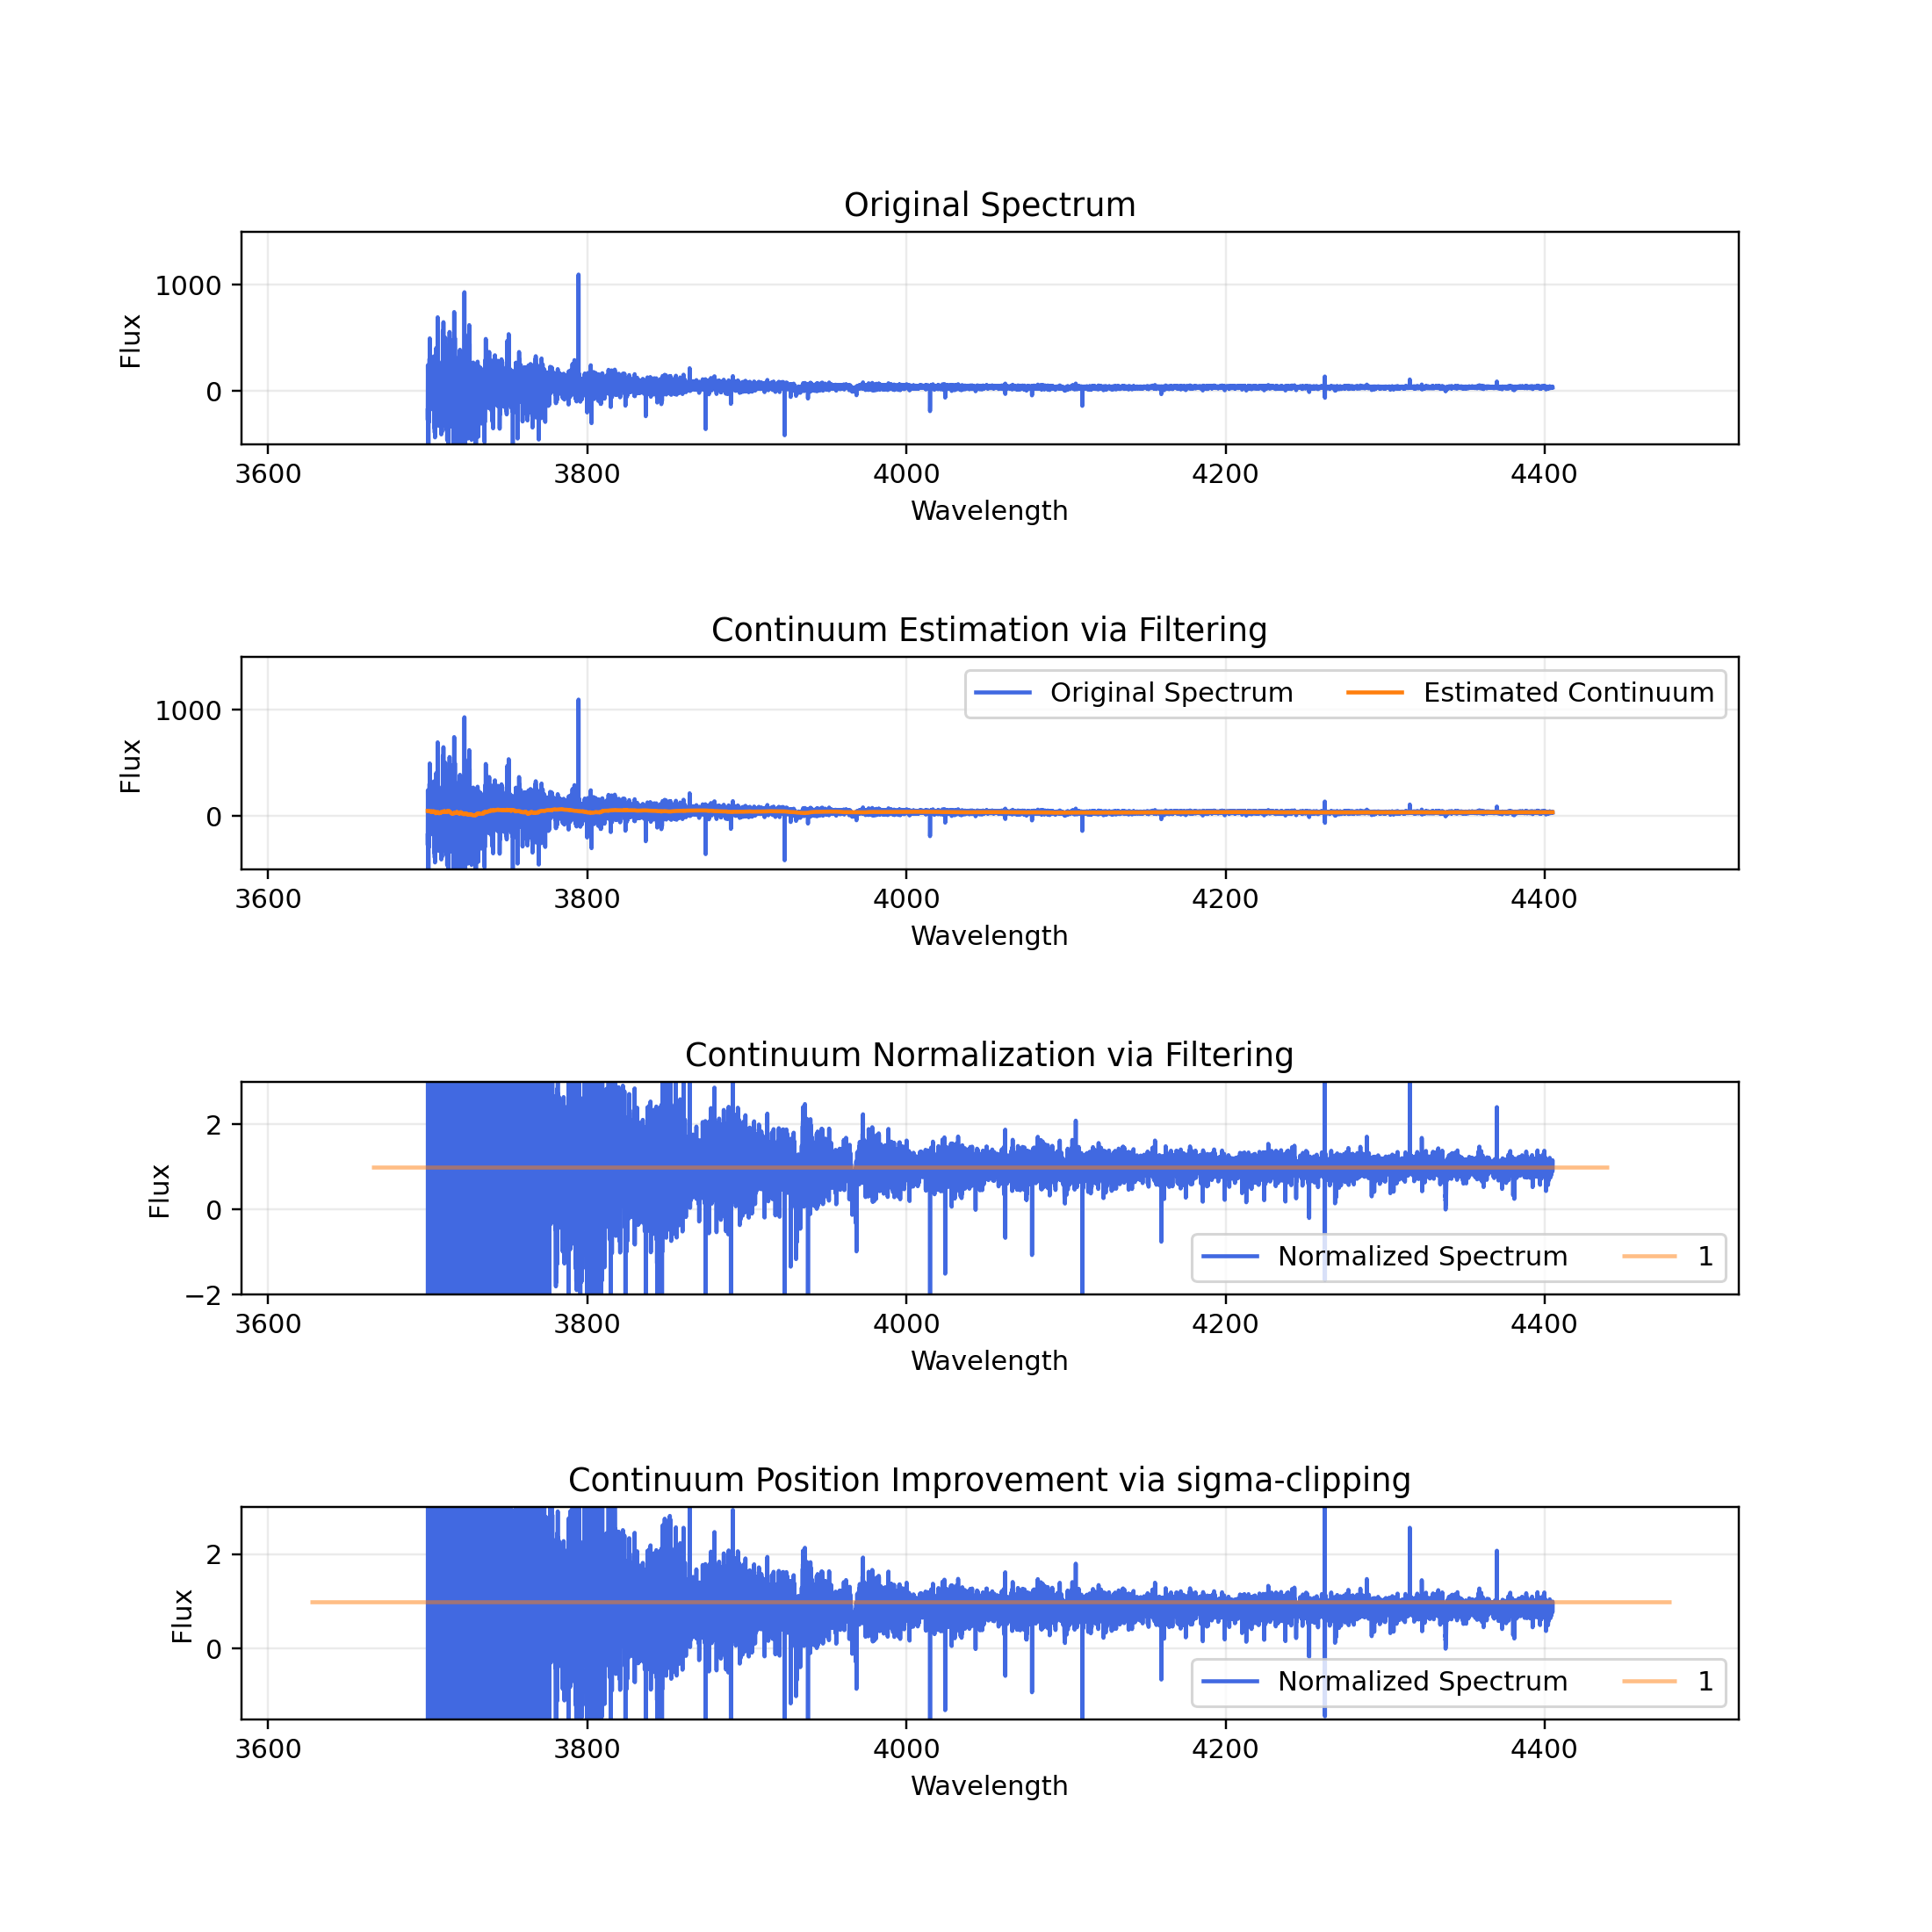

In [17]:
# These plots are to visualize the normalization
%matplotlib notebook
plt.figure(figsize=(10,10))

#-------------------
ax = plt.subplot( 411 )
plt.title('Original Spectrum')
plt.plot( wave, flux , color = colour)
plt.grid(alpha=0.25)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.ylim(-500,1500)

#-------------------
norm, cont = sa.contnorm_filter(flux, smooth_kernel, mode='reflect')

ax2 = plt.subplot( 412, sharex=ax )
plt.title('Continuum Estimation via Filtering')

plt.plot( wave, flux, label='Original Spectrum', color=colour)
plt.plot( wave, cont, label='Estimated Continuum', color=contr)
plt.grid(alpha=0.25)
plt.legend(ncol=2)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.ylim(-500,1500)


#-------------------
ax3 = plt.subplot( 413, sharex=ax )
plt.title('Continuum Normalization via Filtering')

plt.ylim(-2,3)

plt.plot( wave, norm, label='Normalized Spectrum', color = colour)
plt.grid(alpha=0.25)
xmin, xmax = ax.get_xlim()
plt.hlines(1,xmin,xmax, color=contr,zorder=5,alpha=0.5, label='1')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend(ncol=2)

#-------------------
norm2 = sa.contnorm_sigclip(norm, sigma_lower, sigma_upper)

ax4 = plt.subplot( 414, sharex=ax )
plt.title('Continuum Position Improvement via sigma-clipping')

plt.plot( wave, norm2, label='Normalized Spectrum', color = colour)
plt.grid(alpha=0.25)
xmin, xmax = ax.get_xlim()
plt.hlines(1,xmin,xmax, color=contr,zorder=5,alpha=0.5, label='1')
plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.ylim(-1.5,3)

#-------------------
plt.legend(ncol=2)
plt.subplots_adjust(hspace=1)

**OPTIONAL:** Save the result
<br> Once you are satisfied with the auto-normalization, save the spectrum by running the following cell. 

In [18]:
if camera == 'blue':
    section = nblue
else:
    section = ''
save_path = f'{fipath}{star}{num}_{camera}{section}_norm'

print(len(error),len(wave), len(norm))
sa.write2xyz(wave,norm,error, save_path )

16279 16279 16279


### Method B: User specified continuum curve
Zoom into the spectrum and click on where the continuum should be drawn to adda red dot. You may add the reference with `continuum.addReference(turbo_w, turbo_f)` to better visualize it. Once (many of) the red dots draw out a contiinuum curve, click **'return'** to visualize the continuum normalization.

**OPTIONAL:** Save the result
<br> Once you are satisfied with the auto-normalization, save the spectrum by running the following cell. 

<br>Once you have saved your preffered normalization, go back to the top of this routine and normalize the other sections of your spectrum. You should have one _norm.xyz file for the red arm and two for the blue arm (blue1, blue 2).

---
# Calculate  and correct for Radial Velocity 
The following cells will open the files saved from the Normalization routine, and carry their modifications forward without saving them as files. This is why re-runing any of the radial velocity correction cells more than once before restarting the kernel or switching input files will give near-zero radial velocities (the routine will radial-velocity correct spectra that has already been radial-velocity corrected!). 

The first cell in this routine indicates the saved files names and assigns the names of the output files. 
The second cell reads them out (the blue arm is stitched back together) and stores the three columns as a variable that can be modified using the SpecNormRV functions defined in the second cell of this notebook.
The third cell plots the normalized red and blue arms found in the saved files. 

In [19]:
# Naming of Files 

ftyp = 'xyz'
blue1_spec_filename = spath + f'{num}_blue1_norm.{ftyp}' 
blue2_spec_filename = spath + f'{num}_blue2_norm.{ftyp}'
blue_spec_filename  = spath + f'{num}_blue_norm'   
red_spec_filename   = spath + f'{num}_red_norm.{ftyp}'    
# template_filename   = path  + 'norm/metal_poor_template.spec.convol'
template_filename   = '/astro/venn/GHOULS/FIXER_1/norm/metal_poor_template.spec.convol'
rvnorm_blue         = spath + f'{num}_blue_normrv'
rvnorm_red          = spath + f'{num}_red_normrv'
radial_velocities   = spath + f'{num}_radialVelocities.txt'

In [20]:
# Read in the xyz files
data_blue1 = np.genfromtxt(blue1_spec_filename, dtype = None, encoding = None, names = True)
data_blue2 = np.genfromtxt(blue2_spec_filename, dtype = None, encoding = None, names = True)
data_red   = np.genfromtxt(red_spec_filename,   dtype = None, encoding = None, names = True) 

data_blue1['variance'][data_blue1['variance']== 0.] = 1.e6
data_blue2['variance'][data_blue2['variance']== 0.] = 1.e6
data_red['variance'][data_red['variance'] == 0.]  = 1.e6

data_blue1['flux'][~np.isfinite(data_blue1['flux'])]= 0.0
data_blue2['flux'][~np.isfinite(data_blue2['flux'])]= 0.0
data_red['flux'][~np.isfinite(data_red['flux'])]  = 0.0

data_blue1['variance'][~np.isfinite(data_blue1['variance'])] = 1.e6
data_blue2['variance'][~np.isfinite(data_blue2['variance'])] = 1.e6
data_red['variance'][~np.isfinite(data_red['variance'])]   = 1.e6

# Recobine the blue arm 
W,F,V = comb_blue(data_blue1, data_blue2)
sa.write2xyz(W,F,V,blue_spec_filename)
data_blue = np.genfromtxt(blue_spec_filename+'.xyz',dtype = None, encoding = None, names = True)

# Feed to spectra to SpecNormRV function
cand_blue1 = SpecNormRV(data_blue1['wavelength'], data_blue1['flux'], variance = data_blue1['variance'])
cand_blue2 = SpecNormRV(data_blue2['wavelength'], data_blue2['flux'], variance = data_blue2['variance'])
cand_red   = SpecNormRV(data_red['wavelength'],   data_red['flux'],   variance = data_red['variance'])
cand_redCaT   = SpecNormRV(data_red['wavelength'],   data_red['flux'],   variance = data_red['variance'])
cand_redHa  = SpecNormRV(data_red['wavelength'],   data_red['flux'],   variance = data_red['variance'])
cand_blue  = SpecNormRV(data_blue['wavelength'],  data_blue['flux'],  variance = data_blue['variance'])

template = SpectrumTS(template_filename)

<IPython.core.display.Javascript object>


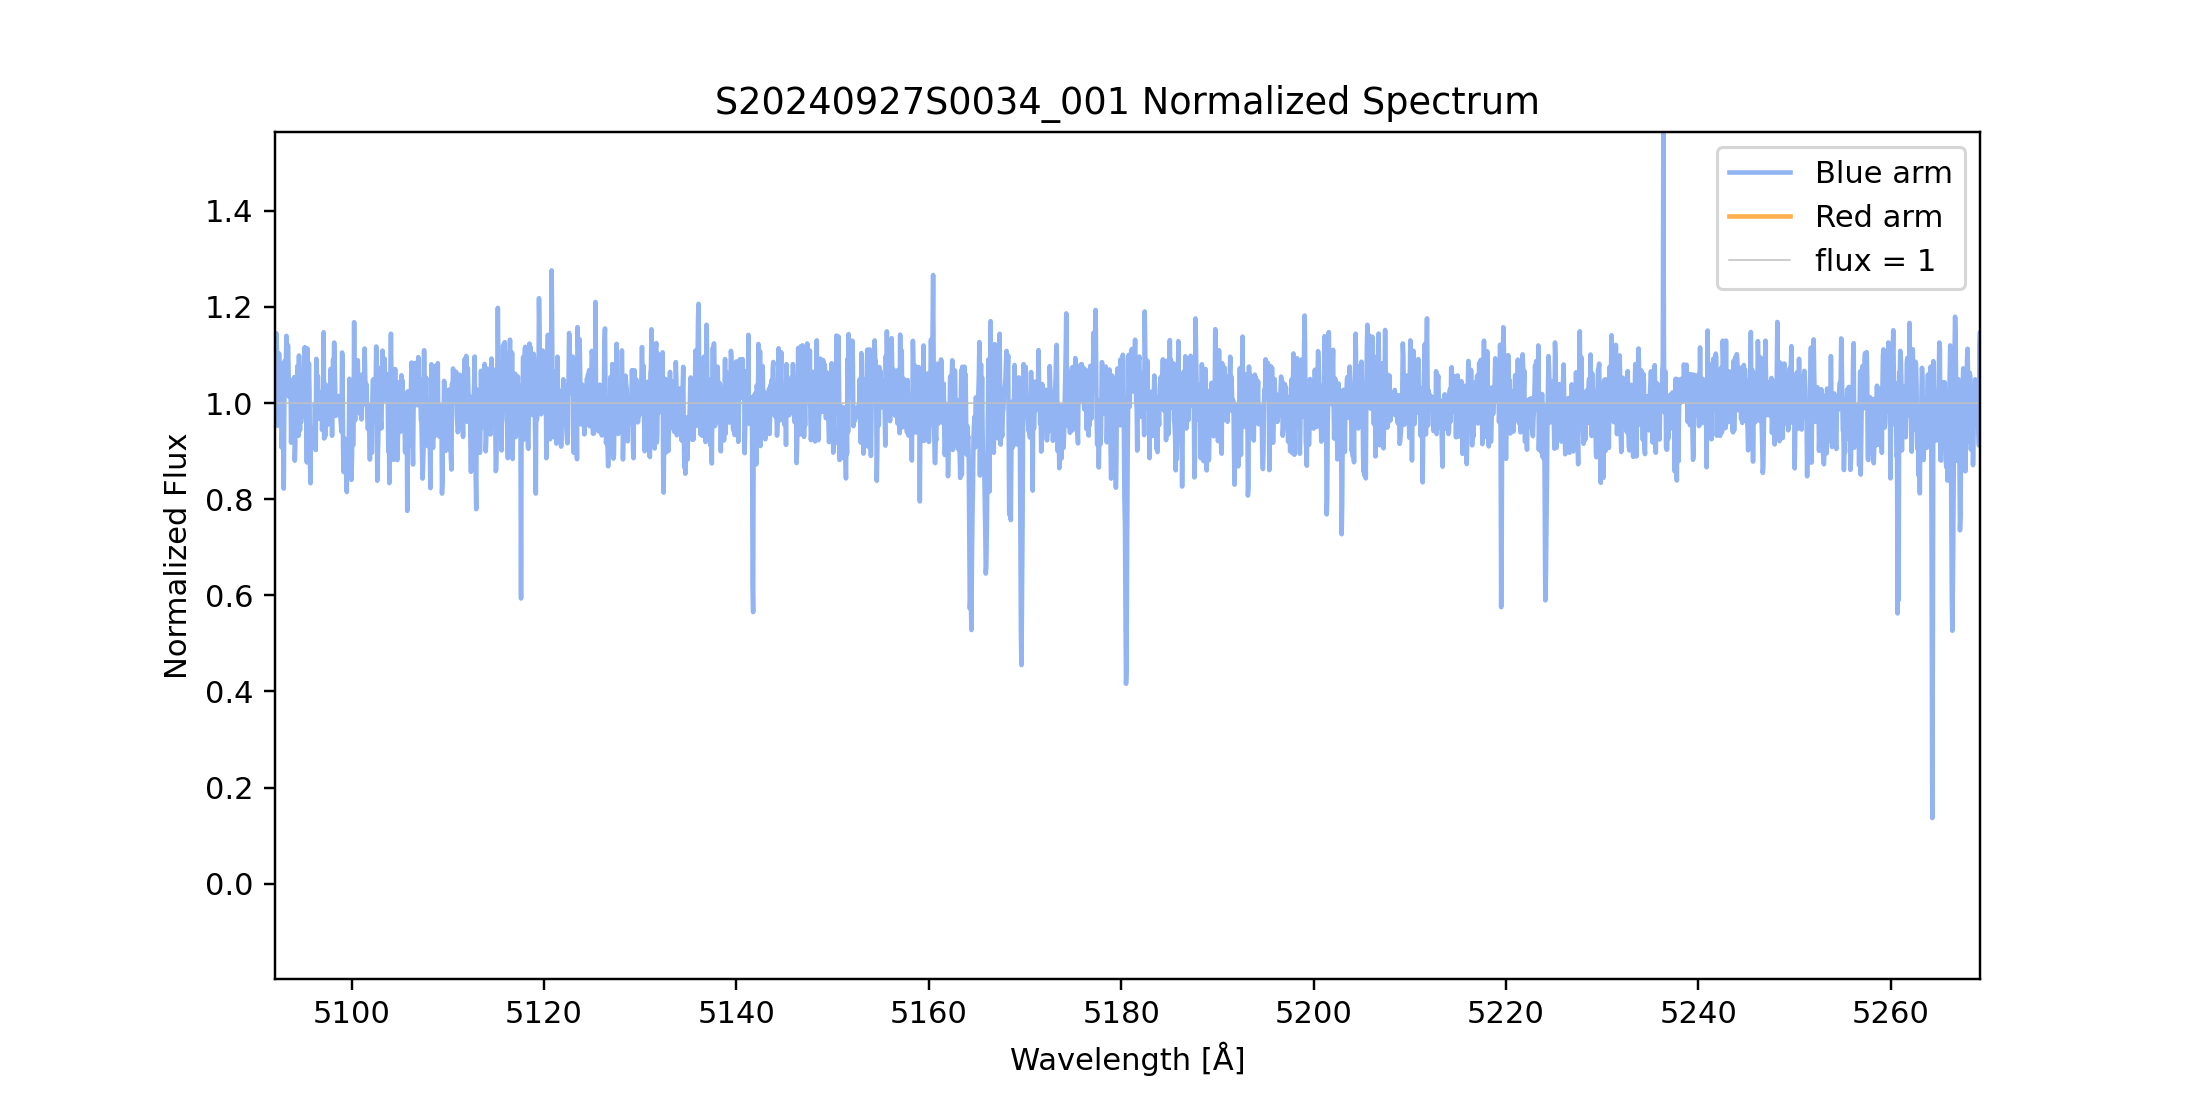

In [21]:
# Plot both arms 
%matplotlib notebook
x = np.linspace(3500,9100,len(cand_red.wavelength))
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.set_ylim(-2,15)
ax.set_title(f'{star}{num} Normalized Spectrum')
ax.set_ylabel('Normalized Flux')
ax.set_xlabel('Wavelength [Å]')

ax.plot(cand_blue.wavelength,cand_blue.flux, c='cornflowerblue', alpha= 0.7,label='Blue arm')
ax.plot(cand_red.wavelength, cand_red.flux,  c='darkorange',alpha= 0.7, label='Red arm')

ax.plot(x, x*0+1, c="silver", linewidth=0.5, label='flux = 1')
ax.legend()

## Calculate RV from cross-correlation
This step uses the metal poor template in norm to cross correlate with the input spectra over selected wavelength ranges. This cell uses 6 diferent ranges to estimate the star's radial velocity: 
- cand_blue1 spans the bluest region of the blue withoit including the noisey end
- cand_blue2 spans from the end of blue1 to the redmost end
- cand_blue is the region including both blue1 and blue2 (used for the rv correction)
- cand_red2 is the bluest region of the red arm (used for rv correction)
- cand_red is the Hα region and it serves as a reference for the user 
- cand_cat  is the Calcium tripplet range which serves as a reference for the user but should not be used for rv correction since it tends to be 0.5-1.0 km/s off

The velocity obtained for each and its uncertainty are printed (in km/s)

In [22]:
# Add the metal poor template 
cand_blue1.add_template(template) ; cand_blue2.add_template(template) ; cand_blue.add_template(template)
cand_red.add_template(template)   ; cand_redHa.add_template(template)  ; cand_redCaT.add_template(template)

# Wavelength range(s) to cross correlate
cand_blue1.rv_correct(wave_range=[4000, 4400], inspect = False)
cand_blue2.rv_correct(wave_range=[4400, 5300], inspect = False)
# cand_blue2.rv_correct(wave_range=[4400, 4900], inspect = False)


cand_blue.rv_correct(wave_range=[4000, 5300], inspect = False)
cand_red.rv_correct(wave_range=[5300, 6000],  inspect = False) # try to 7000
# cand_red2.rv_correct(wave_range=[5300, 5800],  inspect = False)
cand_redHa.rv_correct(wave_range=[6400, 6600],  inspect = False)
cand_redCaT.rv_correct(wave_range=[8400, 8700],  inspect = False)

# These should be almost the same, except for maybe the calcium triplet estimate. 
print('rv-blue(Full):\t'  ,cand_blue.rv,  '\t± ',cand_blue.rv_err)
print('rv-blue1:\t'  ,cand_blue1.rv, '\t± ',cand_blue1.rv_err)
print('rv-blue2:\t'  ,cand_blue2.rv, '\t± ',cand_blue2.rv_err)
print('rv-red:\t'   ,cand_red.rv,  '\t± ',cand_red.rv_err)
print('rv-red(Hα):\t',cand_redHa.rv,   '\t± ',cand_redHa.rv_err)
print('rv-Cat: \t'   ,cand_redCaT.rv,   '\t± ',cand_redCaT.rv_err)

rv-blue(Full):	 -178.616784903246 	±  0.07978921278220165
rv-blue1:	 -178.57923069460395 	±  0.07062633652091517
rv-blue2:	 -178.6191777543019 	±  0.0825300952202065
rv-red:	 -178.2897587896221 	±  0.11896039003285874
rv-red(Hα):	 -178.95554057233238 	±  0.1429978230382903
rv-Cat: 	 -177.48179923364873 	±  0.06411715839013894


## Barycentric correction (OPTIONAL)
The DRAGONS pipeline automatically does a barycentric correction which is why these cells are not used as code by default. However, for some of the comissioning files, DRAGONS is not able to perform the correction. If that is the case for your files, change the format of the follwoing cell to code (from RAW) and use `True` in the save cell below it. 

### Save the radial velocities and their mean in a file for your reference. 
The following cell saves the radial velocities obtained for each of the wavelength ranges as well as a mean (printed) of the trusted ranges (typically blue1, blue2, red2) and corresponding uncertainties in a text file. The cell also saves the radial-velocity corrected red and blue spectra for the IFU in .xyz files.  

In [23]:
# Turn on barycentricvelocity correction if required (TRUE vs FALSE). Off by default
barycentric_velocity_correction = False 

# -----------------------------------------
if barycentric_velocity_correction == True:
    rv_blue1 = cand_blue1.rv_bary ; rv_blue1_e = cand_blue1.rv_err
    rv_blue2 = cand_blue2.rv_bary ; rv_blue2_e = cand_blue2.rv_err
    rv_blue  = cand_blue.rv_bary  ; rv_blue_e  = cand_blue.rv_err
    rv_red   = cand_red.rv_bary   ; rv_red_e   = cand_red.rv_err 
    rv_redCaT   = cand_redCaT.rv_bary   ; rv_redCaT_e   = cand_redCaT.rv_err
    rv_redHa  = cand_redHa.rv_bary  ; rv_redHa_e  = cand_redHa.rv_err
else: 
    rv_blue1 = cand_blue1.rv ; rv_blue1_e = cand_blue1.rv_err
    rv_blue2 = cand_blue2.rv ; rv_blue2_e = cand_blue2.rv_err
    rv_blue  = cand_blue.rv  ; rv_blue_e  = cand_blue.rv_err
    rv_red   = cand_red.rv   ; rv_red_e   = cand_red.rv_err 
    rv_redCaT   = cand_redCaT.rv   ; rv_redCaT_e   = cand_redCaT.rv_err
    rv_redHa  = cand_redHa.rv  ; rv_redHa_e  = cand_redHa.rv_err
# -----------------------------------------

# Indicate which radial_velocities you trust and their corresponding errors (Do not include the Ca triplet)
rvs = [rv_blue1,rv_blue2,rv_red]
# rve = [rv_blue1_e,rv_blue2_e,rv_red2_e]

# -----------------------------------------
mean_rv = sum(rvs)/len(rvs)
rv_err  = np.std(rvs)


# Formating and writing to the Text file 
Des = "Radial velocities in km/s. Estimated by crosscorrelating sections of the spectrum with a metal poor template\n\n"
Top = f'''Blue arm:\t{rv_blue}\t± {cand_blue.rv_err}\nBlue1:\t\t{rv_blue1}\t± {cand_blue1.rv_err}
Blue2:\t\t{rv_blue2}\t± {cand_blue2.rv_err}\nRed2:\t\t{rv_red} \t± {cand_red.rv_err}
Red(Hα):\t{rv_redHa}\t± {cand_redHa.rv_err}\nCa triplet:{rv_redCaT}\t± {cand_redCaT.rv_err}\n\n'''
Res = f'Mean RV:\t{mean_rv}\t± {rv_err}\nComputed with:{rvs}'

# #================================================================================
# with open(radial_velocities,"w") as rv_results:
#     rv_results.write(Des+Top+Res)
# rv_results.close()   

# # Save the RV-corrected normalized spectrum for the Blue and Red arms (Separate)
# sa.write2xyz(cand_blue.wavelength, cand_blue.flux, cand_blue.variance,rvnorm_blue)
# sa.write2xyz(cand_red2.wavelength, cand_red2.flux, cand_red2.variance,rvnorm_red)
# #================================================================================

# Show the mean radial velocity in km/s and the error
print(mean_rv,'±',rv_err)

-178.49605574617598 ± 0.1467827592218511


# Print out blue & red normalized, RV corrected spectrum
This cell reads the radial-velocity corrected files saved in the previous routine and plots the spectrum. It allows to Visualize this notebook's final output. 

In [24]:
datab = np.genfromtxt(rvnorm_blue+'.xyz', dtype = None, encoding = None, names = True)
datar = np.genfromtxt(rvnorm_red +'.xyz', dtype = None, encoding = None, names = True)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.set_ylim(-5,10)
ax.set_title(f'{star}{num} RV-corrected normalized spectrum')
ax.set_ylabel('Normalized Flux')
ax.set_xlabel('Wavelength [Å]')

ax.plot(datab['wavelength'], datab['flux'], c='cornflowerblue' , alpha= 0.7, label='Blue Arm')
ax.plot(datar['wavelength'], datar['flux'], c='darkorange' , alpha= 0.7, label='Red Arm')

x = np.linspace(3600,9200,10000)
ax.plot(x,x*0+1,c="silver",linewidth=0.5, label='Flux = 1')

ax.legend()

FileNotFoundError: /astro/venn/GHOST.data/C19ZZ/S20240927S0034_001_blue_normrv.xyz not found.